In [1]:
import numpy as np
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [11]:
#Load the data of service calls within the US only
df = pd.read_csv('us_locations.csv')
df.head()

city state       actual_category      hours
0   san diego    ca              security   0.100000
1       tampa    fl              software  24.200000
2     raleigh    nc     computer hardware  22.383333
3    portland    or              software   0.933333
4  manchester    nh  access-issue/request  76.733333

In [12]:
#Prepare city/state of geo api 
df['location'] = df['city'].str.cat(df['state'],sep=", ")
df.head()

city state       actual_category      hours        location
0   san diego    ca              security   0.100000   san diego, ca
1       tampa    fl              software  24.200000       tampa, fl
2     raleigh    nc     computer hardware  22.383333     raleigh, nc
3    portland    or              software   0.933333    portland, or
4  manchester    nh  access-issue/request  76.733333  manchester, nh

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


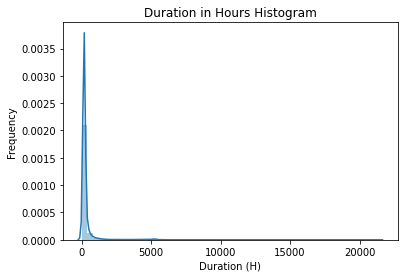

In [ ]:
# CREATE A HISTOGRAM OF Time Duration in Hours
import matplotlib.pyplot as plt 
import seaborn as sns
ax = sns.distplot(df['hours'])
plt.title("Duration in Hours Histogram")
plt.xlabel('Duration (H)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Descriptive stats using plotly violin plots
import plotly.express as px
fig = px.violin(df, y="hours", x="actual_category", box=True, # draw box plot inside the violin
                points="all", 
               )
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Data has several outliers at the upper fence; subsete data based on service calls no greater thatn 3 months; use boxplots to show more vaiation
df2 = df[df.hours<(90*24)]

In [ ]:
import plotly.express as px
fig = px.box(df2, x="actual_category", y="hours", points="all")
fig.show()

In [13]:
#Geocoder will not excute if the datset is too large
#This is the first bin of the data, will try to bin in 5k increments
df3 = df[0:2000]

In [14]:
#Get the geo-locations for each of origin locations
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df3['location2'] = df3['location'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df3['point'] = df3['location2'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df3[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df3['point'].tolist(), index=df3.index)
df3.to_csv('us_loc_2k.csv')
!cp us_loc_2k.csv "drive/My Drive"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [15]:
#Examine the datframe with the new location, lat, lon
df3.head()

city state       actual_category  ...   latitude   longitude altitude
0   san diego    ca              security  ...  32.717420 -117.162773      0.0
1       tampa    fl              software  ...  27.947760  -82.458444      0.0
2     raleigh    nc     computer hardware  ...  35.780398  -78.639099      0.0
3    portland    or              software  ...  45.520247 -122.674195      0.0
4  manchester    nh  access-issue/request  ...  42.995640  -71.454789      0.0

[5 rows x 10 columns]

In [17]:
#Install tokens for mapbox api and produce simple plotly map using mapbox map as the base layer
#You must zoom out to see the map if this is the notebook was reloaded
import plotly.express as px
mapbox_access_token = 'pk.eyJ1IjoidnNtaWxsZXIiLCJhIjoiY2tpMmgwMW10MmZ6cDJ6bnR3cnZ6N2E0eSJ9.Hs3fSyL7D862FtohKmTALg'
px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_mapbox(df3, lat="latitude", lon="longitude", color="actual_category", size="hours",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=10, zoom=10, mapbox_style='dark')
fig.show()

In [18]:
#This map is a heatmap of the ticket time duration in hours; based on locations
fig = px.density_mapbox(df3, lat='latitude', lon='longitude', z='hours', radius=10,
                        center=dict(lat=45, lon=-80), zoom=3,
                        mapbox_style="stamen-terrain")
fig.show()

In [ ]:
#Create a map of the service locations in folium
#Click on the icon to see the category of the the service call
#The map layers can be changed to see the visualization in different base layer views
#Folium maps based on Ryan Noonan tutorial
import folium 
#Create map project
m = folium.Map(location=[38.395, -96.544], zoom_start=5)
#add tiles to the map
folium.raster_layers.TileLayer('Open Street Map').add_to(m)
folium.raster_layers.TileLayer('Stamen Toner').add_to(m)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(m)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(m)

#add layer control to show difference maps
folium.LayerControl().add_to(m)

#plot the location of the service calls
for (index, row) in df3.iterrows():
  folium.Marker(location=[row.loc['latitude'], row.loc['longitude']], popup=row.loc['city']+ '  ' + row.loc['actual_category'],\
                icon=folium.Icon(color='orange',icon='wrench',prefix='fa'), tooltip='click').add_to(m)

#display map
m

In [ ]:
#Create a new dataframe with hours rounded to the tenths 
df4 = df3
df4['hours']=df4['hours'].round(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Create a map that shows the duration of the service tickets in lat/lon 
from folium import plugins 
#Create map project
m2 = folium.Map(location=[38.395, -96.544], zoom_start=5)
#add tiles to the map
folium.raster_layers.TileLayer('Open Street Map').add_to(m2)
folium.raster_layers.TileLayer('Stamen Toner').add_to(m2)
folium.raster_layers.TileLayer('Stamen Terrain').add_to(m2)
folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(m2)

#add layer control to show differenc maps
folium.LayerControl().add_to(m2)

#plot the location of the service calls
for i in df4.itertuples():
  folium.Marker(location=[i.latitude, i.longitude], popup=i.city, icon=plugins.BeautifyIcon(number=i.hours,border_color='blue', \
                                                                                            border_width=1, text_color='orange', 
                                                                                            inner_icon_style='margin-top:0px;')).add_to(m2)

#display map
m2

In [ ]:
#Examine which call center closed the most tickests
#Open the file of the call centers with the number of tickets closted
dfc = pd.read_csv('closed_by.csv')
dfc.head()

city state  number  log_number
0    los angeles    ca   86738    4.938209
1  san francisco    ca    1041    3.017451
2       new york    ny    1295    3.112270
3         dallas    tx     331    2.519828
4    hunt valley    md     807    2.906874

In [ ]:
#Preprocess the data 
dfc['location'] = dfc['city'].str.cat(dfc['state'],sep=", ")
dfc.head()

city state  number  ...   latitude   longitude altitude
0    los angeles    ca   86738  ...  32.717421 -117.162771      0.0
1  san francisco    ca    1041  ...  27.947760  -82.458444      0.0
2       new york    ny    1295  ...  35.780398  -78.639099      0.0
3         dallas    tx     331  ...  45.520247 -122.674195      0.0
4    hunt valley    md     807  ...  42.995640  -71.454789      0.0

[5 rows x 10 columns]

In [ ]:
#Get the geo-locations for each of origin locations
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
dfc['location2'] = dfc['location'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dfc['point'] = dfc['location2'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
dfc[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dfc['point'].tolist(), index=dfc.index)

In [ ]:
#view the data with the updated location, lat, lon
dfc.head()

city state  number  ...   latitude   longitude altitude
0    los angeles    ca   86738  ...  34.053691 -118.242767      0.0
1  san francisco    ca    1041  ...  37.779026 -122.419906      0.0
2       new york    ny    1295  ...  40.712728  -74.006015      0.0
3         dallas    tx     331  ...  32.776272  -96.796856      0.0
4    hunt valley    md     807  ...  39.496271  -76.654257      0.0

[5 rows x 10 columns]

In [ ]:
#Subset the data to include lat, lon, and the number of tickets closed
dfc2= dfc[['latitude','longitude','number']]
dfc2.head()

latitude   longitude  number
0  34.053691 -118.242767   86738
1  37.779026 -122.419906    1041
2  40.712728  -74.006015    1295
3  32.776272  -96.796856     331
4  39.496271  -76.654257     807

In [ ]:
#Create an list of each site for processing the heatmap
site0 = dfc2.loc[0]
site1 = dfc2.loc[1]
site2 = dfc2.loc[2]
site3 = dfc2.loc[3]
site4 = dfc2.loc[4]
site5 = dfc2.loc[5]
site6 = dfc2.loc[6]
site7 = dfc2.loc[7]
site8 = dfc2.loc[8]
site9 = dfc2.loc[9]
site10 = dfc2.loc[10]
site11 = dfc2.loc[11]
site12 = dfc2.loc[12]
site13 = dfc2.loc[13]
site14 = dfc2.loc[14]
site15 = dfc2.loc[15]
site16 = dfc2.loc[16]
site17 = dfc2.loc[17]
site18 = dfc2.loc[18]
site19 = dfc2.loc[19]
site20 = dfc2.loc[20]
site21 = dfc2.loc[21]
site22 = dfc2.loc[22]
site23 = dfc2.loc[23]
site24 = dfc2.loc[24]
site25 = dfc2.loc[25]
site26 = dfc2.loc[26]
site27 = dfc2.loc[27]
site28 = dfc2.loc[28]
site29 = dfc2.loc[29]
site30 = dfc2.loc[30]
site31 = dfc2.loc[31]
site32 = dfc2.loc[32]
closed_by_list = [site0, site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,site11,site12,site13,site14,site15,site16,site17,site18,site19,site20,\
                  site21,site22,site23,site24,site25,site26,site27,site28,site29,site30,site31,site32]


In [ ]:
#Create a heatmap of the number of tickets closed by site location
from folium import plugins
map_heatmap1 = folium.Map([39.394, -96.544], tiles= "CartoDB dark_matter",zoom_start=5)
plugins.HeatMap(closed_by_list).add_to(map_heatmap1)
map_heatmap1